# JAX-CFD channel flow demo

This demonstration shows how to use JAX-CFD to simulate 2d flow between parallel no-slip walls.

In [4]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import jax_cfd.base as cfd
import xarray

In [5]:
size = (512, 128)
domain = ((0, 8), (0, 2))
density = 1.
viscosity = 1e-3  # kinematic visocity
pressure_gradient = 2e-3  # uniform dP/dx

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid(size, domain=domain)

# Specify periodic BC on x-boundaries, and no-slip walls on the y-boundaries.
velocity_bc = (cfd.boundaries.channel_flow_boundary_conditions(ndim=2),
               cfd.boundaries.channel_flow_boundary_conditions(ndim=2))

# Specify zero velocity initial conditions
vx_fn = lambda x, y: jnp.zeros_like(x + y)
vy_fn = lambda x, y: jnp.zeros_like(x + y)

v0 = cfd.initial_conditions.initial_velocity_field(
    velocity_fns=(vx_fn, vy_fn),
    grid=grid,
    velocity_bc=velocity_bc,
    pressure_solve=cfd.pressure.solve_fast_diag_channel_flow,
    iterations=5)

# Confirm that the divergence of v0 is zero
div = cfd.finite_differences.divergence(v0)
np.testing.assert_allclose(div.data, 0)

# Specify a fixed time step based on the convection and diffusion scales
max_velocity = 1  # value selected from known equilibirum profile
cfl_safety_factor = 0.5

dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

In [6]:
# Define a linear force due to the uniform pressure gradient
def pressure_gradient_forcing(pressure_gradient: float):
  
  def forcing(v):
    force_vector = (pressure_gradient, 0)
    return tuple(cfd.grids.GridArray(f * jnp.ones_like(u.data), u.offset, u.grid)
                 for f, u in zip(force_vector, v))
  
  return forcing

In [7]:
# time steps per output
inner_steps = 10_000

# number of outputs
outer_steps = 12

# TODO(pnorgaard): Fix Van-Leer limiters for Dirichlet velocity BC 
def convect(v):
  return tuple(
      cfd.advection.advect_van_leer(u, v, dt) for u in v)
  
# Define a step function and use it to compute a trajectory.
step_fn = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve=cfd.pressure.solve_fast_diag_channel_flow,
        forcing=pressure_gradient_forcing(pressure_gradient),
        ),
    steps=inner_steps)
rollout_fn = jax.jit(cfd.funcutils.trajectory(
    step_fn, outer_steps, start_with_input=True))

%time _, trajectory = jax.device_get(rollout_fn(v0))

CPU times: user 9.42 s, sys: 2.9 s, total: 12.3 s
Wall time: 12.3 s


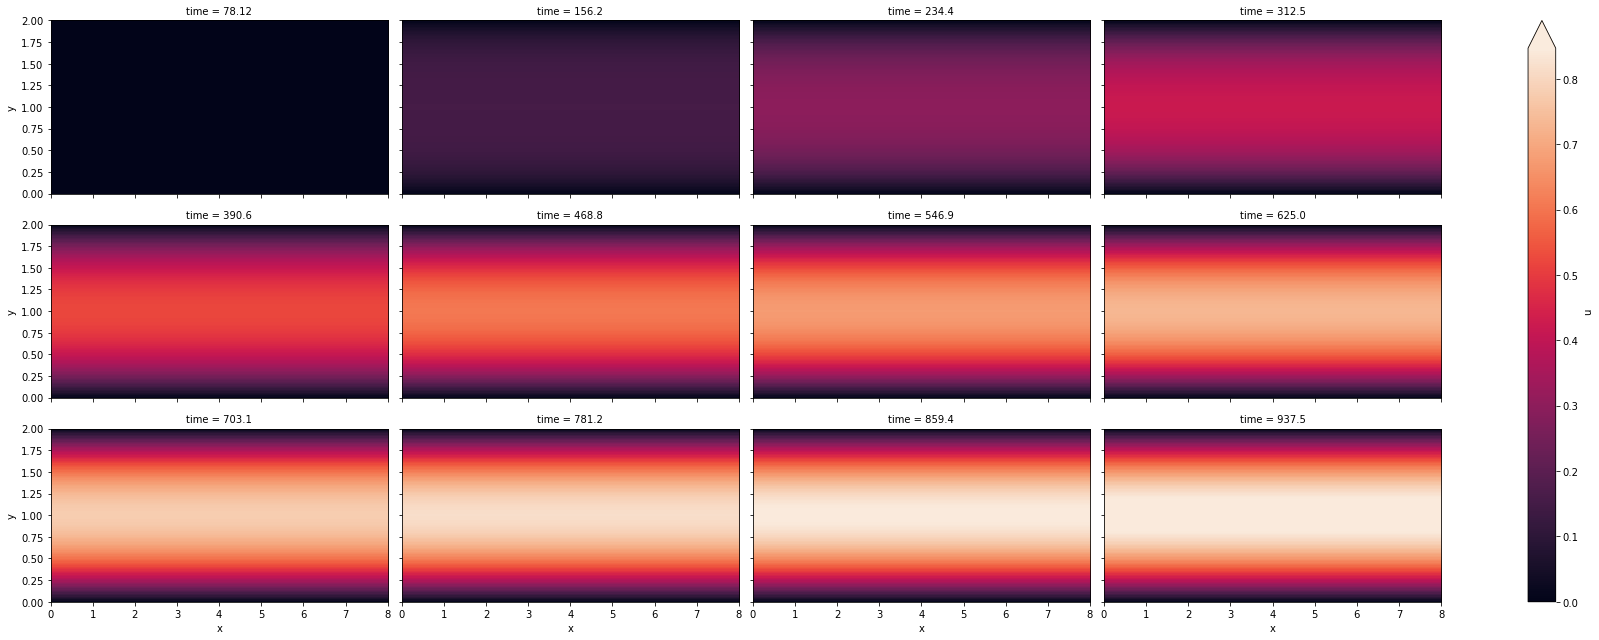

In [8]:
# load into xarray for visualization and analysis
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data),
        'v': (('time', 'x', 'y'), trajectory[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(1, outer_steps + 1)
    }
)

# Plot the x-velocity
ds.pipe(lambda ds: ds.u).plot.imshow(
    'x', 'y', col='time',cmap=seaborn.cm.rocket, robust=True, col_wrap=4, aspect=2);

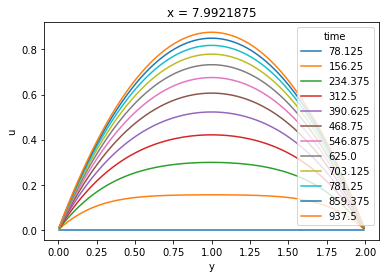

In [9]:
def vx_at_x_upper_boundary(ds):
  return ds.u.isel(x=-1)  # slice operator

p = ds.pipe(vx_at_x_upper_boundary).plot(hue='time')